# Modified version of Deep Operator Network

* We import the necessary library

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as onp
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.experimental import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu
from jax.config import config
from jax.ops import index_update, index




import itertools
from functools import partial
from torch.utils import data
from tqdm import trange

from scipy import interpolate
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Architecture:

* We outline the following multi-layer perceptron for an input of $u \in \mathbb{R}^{m}$ and $y \in \mathbb{R}^{d}$:

* We consider the branch and trunk neural networks to be a network with 1 hidden layer with $p$ neurons: 

- Branch network: 

1. Input layer: $ B^{(0)} = u \in \mathbb{R}^{m}$

2. First layer: $W^{(1)} \in \mathbb{R}^{p \times m}$ and $\delta^{(1)} \in \mathbb{R}^{p}$: 

$$
B^{(1)} = \sigma \Big( W^{(1)} B^{(0)} + \delta^{(1)}    \Big)
$$


- Trunk network: 

1. Input layer: $T^{(0)} = y \in \mathbb{R}^{d}$


2. First layer: 


- Let $H_{1}^{(1)} \in \mathbb{R}^{p \times m}, H_{2}^{(1)} \in \mathbb{R}^{1\times d}, H_{3}^{(1)} \in \mathbb{R}^{p \times d}, q^{(1)} \in \mathbb{R}^{p}$

We calculate the weight matrix: 

$$
W^{(1)} = \sigma \Big( H_{1}^{(1)}\cdot u \cdot H_{2}^{(1)} + H_{3}^{(1)}   \Big)  \in \mathbb{R}^{p \times d}
$$

We calculate the bias: 


$$
b^{(1)} = \sigma \Big(  H_{1}^{(1)}\cdot u  + q^{(1)}     \Big) \in \mathbb{R}^{p}
$$

The output value of trunk network: 

$$
T^{(1)} = \sigma \Big( W^{(1)} T^{(0)} + b^{(1)}   \Big) \in \mathbb{R}^{p}
$$

The final output of approximating the operator $G(u)(y)$ is as follows: 


$$
G(u)(y) = (B^{(1)})^{T} (T^{(1)})
$$


In [2]:
# Define the neural net
def MLP(branch_layers,trunk_layers, activation=relu):
    def init_branch(rng_key):
        """The function to initialize the weights and bias for branch network using Xavier initialization"""
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev*random.normal(k1, (d_in, d_out)) # initialize with Glorot normal.
            b = glorot_stddev*random.normal(k1, shape = (d_out,)) ## random normal initialization. 
            return W.T, b[:,None] #shape (p,m) ; (p,1)
        key, *keys = random.split(rng_key, len(branch_layers))
        params = list(map(init_layer, keys, branch_layers[:-1], branch_layers[1:]))
        return params #(W,b)
    
    def init_trunk(rng_key):
        """Similar as init_branch using Xavier initialization"""
        """The params1 is the storage of W_hat1, b_hat1; The params2 is the storage of W_hat2, W_hat3."""
        branch_layers_scaled = branch_layers[:-1]
        trunk_layers_scaled = branch_layers_scaled+trunk_layers[1:-1] 
        def init_layer_1(key,d_in,d_out):
            k1,k2 = random.split(key)
            glorot_std = 1./np.sqrt((d_in+d_out)/2.)
            W_hat1 = glorot_std*random.normal(k1,shape = (d_in, d_out))
            b_hat = glorot_std*random.normal(k1,shape = (d_out,))
            return W_hat1.T, b_hat #shape: (p,m); (p,1)
        
        key, *keys = random.split(rng_key, len(trunk_layers_scaled))
        params1 = list(map(init_layer_1, keys, trunk_layers_scaled[:-1], trunk_layers_scaled[1:]))
        
        def init_layer_2(key,d_in, d_out):
            k1,k2 = random.split(key)
            glorot_std = 1./np.sqrt((d_in+d_out)/2.)
            W_hat2 = glorot_std * random.normal(k1, shape = (d_in,))
            W_hat3 = glorot_std * random.normal(k1, shape = (d_in,d_out))
            return W_hat2[:,None], W_hat3.T #shape: (1,d) ; (p,d)
        
        key, *keys = random.split(rng_key, len(trunk_layers))
        params2 = list(map(init_layer_2, keys, trunk_layers[:-1], trunk_layers[1:]))
        return params1,params2 
    
    def branch_apply(branch_params, u_vector):
        """Calculate the branch output for a single vector input u in R^m"""
        u_vector = u_vector[:,None] # column vector. 
        for W, b in branch_params[:-1]:
            output_branch = activation(W @ u_vector + b)
        return output_branch
        
    def trunk_apply(trunk_params1, trunk_params2,u_vector,y_vector):
        """Calculate the trunk output for a single vector input u and y in R^m, R^d respectively."""
        u_vector, y_vector = u_vector[:,None], y_vector[:,None] ## column vector.
        for W_hat1, b_hat1 in trunk_params1[:-1]:
            for W_hat2, W_hat3 in trunk_params2[:-1]: 
                b_hat1 = b_hat1[:,None] # reshape into column vector. 
                Weight_Trunk = activation( W_hat1 @ u_vector @ W_hat2 + W_hat3) ## apply the transformation
                Bias_Trunk = activation( W_hat1 @ u_vector + b_hat1) ## apply the transformation 
                Trunk_Params = list([Weight_Trunk, Bias_Trunk]) 
                output_trunk = activation( Weight_Trunk @ y_vector + Bias_Trunk) ## output of the trunk 
        return Trunk_Params, output_trunk
        
    return init_branch, init_trunk, branch_apply, trunk_apply

In [3]:
m = 50
p = 40 
branch_layers =  [m,p,p]
dim_x = 1
key = random.PRNGKey(12345)
trunk_layers = [dim_x,p,p]
init_branch, init_trunk,branch_apply, trunk_apply = MLP(branch_layers, trunk_layers)
branch_params = init_branch(rng_key = random.PRNGKey(1234))
trunk_params1, trunk_params2 = init_trunk(rng_key = random.PRNGKey(1234))

* Generate the random vector for u and y with $2$ number of data. 

In [4]:
num_train = 2
u = random.normal(key, shape = (num_train,m))
y = random.normal(key, shape = (num_train, dim_x))
print(u.shape)
print(y.shape)

(2, 50)
(2, 1)


* We test with the following vector

In [5]:
u_vec1 = u[0,:]
y_vec1 = y[0,:]
u_vec2 = u[1,:]
y_vec2 = y[1,:]

In [6]:
Bout_1 = branch_apply(branch_params, u_vec1)
Tout_1 = trunk_apply(trunk_params1, trunk_params2, u_vec1, y_vec1)[1]
print(Bout_1.shape)
print(Tout_1.shape)

(40, 1)
(40, 1)


In [7]:
Bout_2 = branch_apply(branch_params, u_vec2)
Tout_2 = trunk_apply(trunk_params1, trunk_params2, u_vec2, y_vec2)[1]
print(Bout_2.shape)
print(Tout_2.shape)

(40, 1)
(40, 1)


# Deep Operator Architecture

In [46]:
class DeepOperator:
    def __init__(self,branch_layers, trunk_layers): 
        self.branch_init, self.trunk_init, self.branch_apply, self.trunk_apply = MLP(branch_layers, trunk_layers, activation = relu)
        key_random = random.PRNGKey(1234)
        branch_params = self.branch_init(rng_key = key_random)
        trunk_params1, trunk_params2 = self.trunk_init(rng_key = key_random)
        
        params = (branch_params,trunk_params1, trunk_params2)
        
        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(optimizers.exponential_decay(1e-4, decay_steps = 1000, decay_rate = 0.9))
        
        self.opt_state = self.opt_init(params) # initialize the parameters. 
        self.itercount = itertools.count()
        # Logger
        self.loss_log = [] ## initialize to store the loss values. 
        self.epoch_log =[] ## epoch storage.
    
    def operator_net(self, params, u, y):
        branch_params, trunk_params1, trunk_params2 = params
        num = u.shape[0]
        Output = np.zeros(shape = (num,1), dtype = np.float32)
        ## this loop slows down: 
        for i in range(num):
            u_vector = u[i,:]
            y_vector = y[i,:]
            Branch_output = self.branch_apply(branch_params, u_vector)
            Trunk_output = self.trunk_apply(trunk_params1, trunk_params2, u_vector, y_vector)[1]
            Computed_Value = (Branch_output.T @ Trunk_output)[0][0]
            index_val = index[i]
            Output = index_update(Output, index_val, Computed_Value)
        return Output

    def loss_operator(self, params, batch_data):
        """Take the data and apply the operator net function to compute B.T@Trunk for a whole dataset."""
        inputs, labels = batch_data
        u,y = inputs 
        ## compute the forward pass: 
        pred = self.operator_net(params, u,y)
        ## compute the loss values: 
        loss = np.mean((labels.flatten() - pred)**2) ## we compute the mean squared error loss. 
        return loss
    
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        grad_values = grad(self.loss_operator)(params, batch)## compute the gradient function  
        update_value = self.opt_update(i, grad_values, opt_state)
        return update_value
    
    # Optimize parameters in the loop: 
    def train(self, dataset, epochs = 20000,print_every =  100):
        data = iter(dataset)
        pbar = trange(epochs) ## progressing bar. 
        ## training loop: 
        for it in pbar: 
            batch_data = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch_data)
            params = self.get_params(self.opt_state)
            ## compute the loss values: 
            loss_value = self.loss_operator(params, batch_data)
            if (it % print_every == 0):
                self.loss_log.append(loss_value) 
                self.epoch_log.append(it)
                pbar.set_postfix({'Iteration': it, 'Loss Values': loss_value}) ## update the progress bar


# Data Generator: 

* We define the operator space: 

1. Operator Data: 
- $m$: the nunber of sensors (Choose $m = 50$). 
- $m_{u}$: number of u's (Choose $m_{u} = 60$). 
- $m_{y}$: number of y's (Choose $m_{y} = 40$). 
2. Functional Basis: 
- $N$: number of elements in polynomial basis (Choose $N = 100$). 
- $M$: range of polynomial basis coefficients [-M, M] (Choose $M = 1$)

3. Neural Network: 
- $n$: number of branch neurons (choose $n = 40$). 
- $p$: number of trunk neurons (choose $p = 40$). 

* Expected: 

- features: an $m_{u}$-by-$N$ matrix i.e number of u's by number of basis functions. 
- sensor values (input samples u): $m_{u}$-by-$m$ matrix i.e number of u's by number of sensor values. 

* Data: Operator data is of the form $(u, y, G(u)(y) )$ - triplet datapoint. 

- The dimension for a training data-set $u$ is $(m_{u} \times m_{y}, m)$. 
- The dimension for a training data-set $y$ is $(m_{u} \times m_{y}, dim_{y})$. 
- For the operator $s$ is of $(m_{u} \times m_{y}, 1)$.

In [19]:
# Length scale of a Gaussian random field (GRF)
length_scale = 0.2

# Define Radial-Basis Function
def RBF(x1, x2,output_scale = 1, lengthscales= length_scale):
    diffs = np.expand_dims(x1 / lengthscales, 1) - np.expand_dims(x2 / lengthscales, 0) 
    r2 = np.sum(diffs**2, axis=2) ## compute the L2 norm || x1 - x2 ||_{2}
    return output_scale*np.exp(-0.5 * r2)

# Geneate training data corresponding to one input sample
def generate_one_data(key,m, m_y):
    # Sample GP prior at a fine grid
    N = 100
    jitter = 1e-10
    X = np.linspace(0, 1, N)[:,None]
    K = RBF(X, X)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(key, (N,))) # one Gaussian sample. 

    # Create a callable interpolation function  
    u_fn = lambda x, t: np.interp(t, X.flatten(), gp_sample)

    # Input sensor locations and measurements
    x = np.linspace(0, 1, m) # a single feature vector. 
    u = vmap(u_fn, in_axes=(None,0))(0.0, x)

    # Output sensor locations and measurements
    y_train = random.uniform(key, (m_y,)).sort() 
    s_train = odeint(u_fn, 0.0, np.hstack((0.0, y_train)))[1:] 
    # bug: always returns s(0), so add a dummy entry to y and return s[1:]

    # Tile inputs
    u_train = np.tile(u, (m_y,1))

    return u_train, y_train, s_train

# Geneate training data corresponding to N input sample
def generate_operator_data(key, m, m_y, m_u):
    config.update("jax_enable_x64", True)
    keys = random.split(key, m_u)
    gen_fn = jit(lambda key: generate_one_data(key, m, m_y))
    u_train, y_train, s_train = vmap(gen_fn)(keys)
    m_G = m_u * m_y # number of training data. 
    u_train = np.float32(u_train.reshape(m_G,-1))
    y_train = np.float32(y_train.reshape(m_G,-1))
    s_train = np.float32(s_train.reshape(m_G,-1))

    config.update("jax_enable_x64", False)
    return u_train, y_train, s_train

In [20]:
# Data generator
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample
        self.y = y # location
        self.s = s # labeled data evulated at y (solution measurements, BC/IC conditions, etc.)
        
        self.m_G = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.m_G, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

In [21]:
m = 50 # sensors 
m_u = 60 # number training u's 
m_y = 40 # number training y's
key = random.PRNGKey(0) # key for generating the data. 
u_train, y_train, s_train = generate_operator_data(key,m,m_y,m_u)

In [22]:
print(u_train.shape)
print(y_train.shape)
print(s_train.shape)

(2400, 50)
(2400, 1)
(2400, 1)


In [47]:
dim_d = 1
branch_layers = [m,p,p]
trunk_layers = [dim_d,p,p]
model = DeepOperator(branch_layers, trunk_layers)

## Training the model

* We train the model with small epochs to see first: 

In [48]:
DataTrain = DataGenerator(u_train, y_train, s_train, batch_size = 10)

In [49]:
Epochs = 20000
print_every = 10
model.train(DataTrain, epochs = Epochs, print_every = print_every)

100%|██████████| 20000/20000 [31:38<00:00, 10.53it/s, Iteration=2e+4, Loss Values=0.277985]     


* We plot the training loss value:

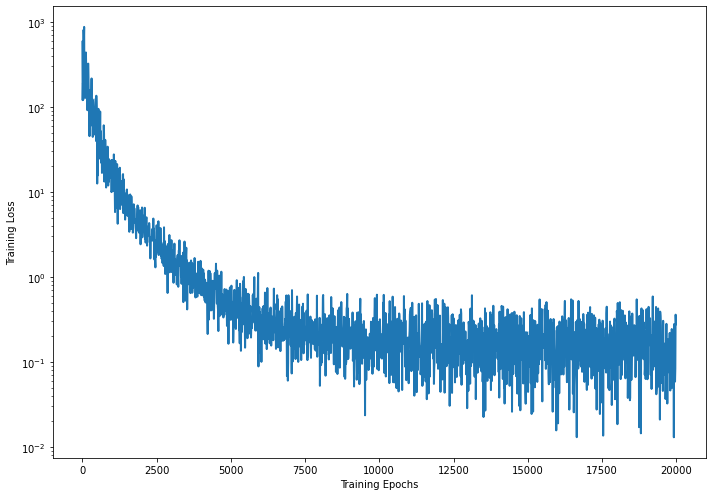

In [50]:
## extract the loss values: 
lossValues = np.array(model.loss_log)
epochValues = np.array(model.epoch_log)
plt.figure(figsize = (10,7))
plt.plot(epochValues,lossValues, lw = 2)
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.yscale('log') ## convert to log-scale. 
plt.tight_layout()
plt.show()